# 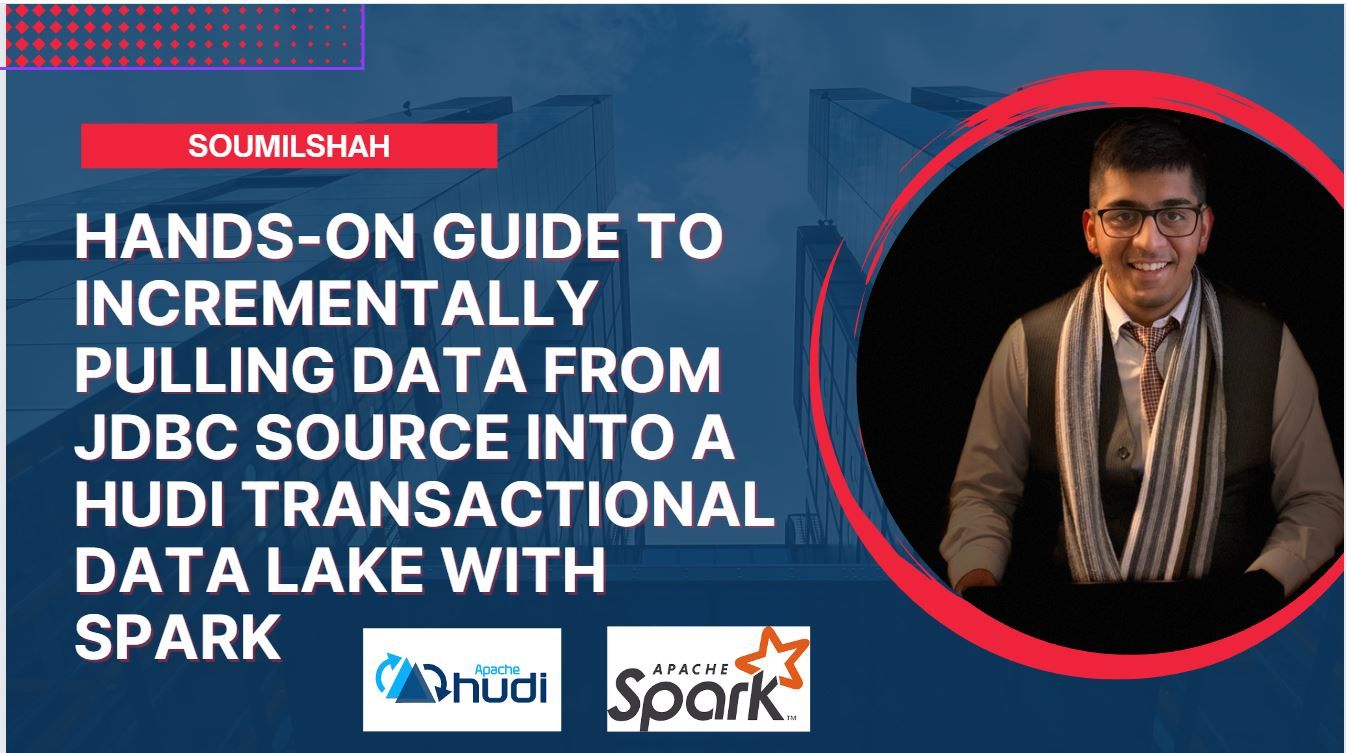

* Unlocking Incremental Data in PySpark: Extracting from JDBC Sources without Debezium or AWS DMS with CDC
* Link https://www.linkedin.com/pulse/unlocking-incremental-data-pyspark-extracting-from-jdbc-soumil-shah-1e/?trackingId=mto8Qta5QweEwHXnX8mWZQ%3D%3D

# Step 1: Define Imports 

In [2]:
try:

    import os
    import sys
    import uuid

    import pyspark
    from pyspark.sql import SparkSession
    from pyspark import SparkConf, SparkContext
    from pyspark.sql.functions import col, asc, desc
    from pyspark.sql.functions import col, to_timestamp, monotonically_increasing_id, to_date, when
    from pyspark.sql.functions import *
    from pyspark.sql.types import *
    from datetime import datetime
    from functools import reduce
    from faker import Faker
except Exception as e:
    pass


# Step 2: Create Spark Session 

In [3]:
SUBMIT_ARGS = "--packages org.postgresql:postgresql:42.5.4,org.apache.hudi:hudi-spark3.3-bundle_2.12:0.12.1 pyspark-shell"

os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .config('spark.serializer', 'org.apache.spark.serializer.KryoSerializer') \
    .config('spark.sql.extensions', 'org.apache.spark.sql.hudi.HoodieSparkSessionExtension') \
    .config('className', 'org.apache.hudi') \
    .config('spark.sql.hive.convertMetastoreParquet', 'false') \
    .getOrCreate()

spark

# Step 3: Define Hudi Settings and JDBC Settings 

In [7]:
# ======================================= Settings ===============================
global spark, jdbc_url, table_name, user, password, pk, updated_at_column_name, driver

jdbc_url = 'jdbc:postgresql://localhost:5432/postgres'
table_name = 'public.sales'
user = 'postgres'
password = 'postgres'
pk = "salesid"
updated_at_column_name = "updated_at"
driver = 'org.postgresql.Driver'

# ======================================= HUDI Settings ===============================
db_name = "hudidb"
hudi_table = "sales"
recordkey = 'salesid'
path = f"file:///C:/tmp/{db_name}/{hudi_table}"
precombine = "updated_at"
method = 'upsert'
table_type = "COPY_ON_WRITE"  # COPY_ON_WRITE | MERGE_ON_READ
# ===============================================================================================


hudi_options = {
    'hoodie.table.name': table_name,
    'hoodie.datasource.write.recordkey.field': recordkey,
    'hoodie.datasource.write.table.name': table_name,
    'hoodie.datasource.write.operation': method,
    'hoodie.datasource.write.precombine.field': precombine,
}


# Step 4: Define helper class 

In [8]:
class Parameters:
    def __init__(self):
        self.first_time_read_flag = False
        self.prev_commit = 0
        self.prev_updated_date = "2000-01-01"
        self.insert_data_exists_flag = False
        self.update_data_exists_flag = False


class Checkpoints(Parameters):
    def __init__(self, directory="./checkpoint/max_id", table_name="sales"):
        self.directory = directory
        self.table_name = table_name
        Parameters.__init__(self)

    def read(self):
        if self.is_exists():
            self.prev_commit, self.prev_updated_date, self.table_name = spark.read.csv(self.directory).collect()[0]
            return True
        else:
            self.first_time_read_flag = True
            return False

    def write(self):
        spark_df = spark.createDataFrame(data=[(str(self.prev_commit), str(self.prev_updated_date), self.table_name)],
                              schema=['prev_commit', "prev_updated_date", "table_name"])
        spark_df.write.mode("overwrite").csv(self.directory)

        return True

    def is_exists(self):
        if os.path.exists(self.directory):
            print(f"Checkpoint found ")
            return True
        else:
            print(f"Checkpoint Not found ")
            return False


class QuerySource(object):
    def __init__(self, pk_auto_inc_column_name, updated_at_column_name, check_point_instance):
        self.pk_auto_inc_column_name = pk_auto_inc_column_name
        self.updated_at_column_name = updated_at_column_name
        self.check_point_instance = check_point_instance

    def get_inc_insert(self):
        query = f"SELECT * FROM {self.check_point_instance.table_name} WHERE {self.pk_auto_inc_column_name} > {self.check_point_instance.prev_commit}"

        df = spark.read.format('jdbc').options(
            url=jdbc_url,
            query=query,
            user=user,
            password=password,
            driver=driver
        ).load()
        if df.count() >= 0: self.check_point_instance.insert_data_exists_flag = True
        return df

    def get_inc_update(self):
        query = f"SELECT * FROM {self.check_point_instance.table_name} WHERE {self.updated_at_column_name} > '{self.check_point_instance.prev_updated_date}'"

        df = spark.read.format('jdbc').options(
            url=jdbc_url,
            query=query,
            user=user,
            password=password,
            driver=driver
        ).load()
        if df.count() >= 0: self.check_point_instance.update_data_exists_flag = True
        return df


def get_spark_df():
    now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    helper_check_points = Checkpoints(
        directory="./checkpoint/max_id",
        table_name=table_name,
    )
    helper_check_points.read()

    query_instance = QuerySource(
        pk_auto_inc_column_name=pk,
        updated_at_column_name=updated_at_column_name,
        check_point_instance=helper_check_points
    )

    if helper_check_points.first_time_read_flag:
        insert_inc_df = query_instance.get_inc_insert()

        helper_check_points.prev_commit = insert_inc_df.agg({pk: "max", updated_at_column_name: "max"}).collect()[0][0]

        helper_check_points.prev_updated_date = \
        insert_inc_df.agg({pk: "max", updated_at_column_name: "max"}).collect()[0][1]

        helper_check_points.write()

    else:
        insert_inc_df = query_instance.get_inc_insert()
        update_inc_df = query_instance.get_inc_update()
        current_commit = insert_inc_df.agg({pk: "max", updated_at_column_name: "max"}).collect()[0][0]

        current_updated_date = update_inc_df.agg({pk: "max", updated_at_column_name: "max"}).collect()[0][1]

        if current_commit is not None and helper_check_points.insert_data_exists_flag:
            if current_commit > helper_check_points.prev_commit:
                helper_check_points.prev_commit = current_commit

        if current_updated_date is not None and helper_check_points.update_data_exists_flag:
            if current_updated_date.__str__() > helper_check_points.prev_updated_date.__str__() :
                helper_check_points.prev_updated_date = current_updated_date

    result = None
    helper_check_points.write()

    if helper_check_points.first_time_read_flag:
        result = insert_inc_df
    else:
        result = insert_inc_df.union(update_inc_df)
    
    return result

# Inserting INC data from Source into Hudi Datalake

In [10]:
spark_df = get_spark_df()
print(spark_df.show(3))
print("\n")

if spark_df.count() >=0:
    spark_df.write.format("hudi"). \
    options(**hudi_options). \
    mode("append"). \
    save(path)

Checkpoint found 
+-------+---------+------+-----------------+-----+--------+----------+----------------+------------+---------+--------------------+
|salesid|invoiceid|itemid|         category|price|quantity| orderdate|destinationstate|shippingtype| referral|          updated_at|
+-------+---------+------+-----------------+-----+--------+----------+----------------+------------+---------+--------------------+
|      8|    15371|    97|soumil updated it|36.00|       4|2016-06-12|              TN|       2-Day|Online Ad|2023-04-20 11:08:...|
+-------+---------+------+-----------------+-----+--------+----------+----------------+------------+---------+--------------------+

None




# Read froom Hudi Datalake

In [20]:
df = spark. \
      read. \
      format("hudi"). \
      load(path)
df.select(["salesid","updated_at", "category"]).show()

+-------+--------------------+---------+
|salesid|          updated_at| category|
+-------+--------------------+---------+
|     21|2023-04-20 10:32:...|   Garden|
|     20|2023-04-20 10:32:...|  Kitchen|
|      4|2023-04-20 10:32:...|  Kitchen|
|     31|2023-04-20 10:32:...|   Garden|
|     40|2023-04-20 10:32:...|   Office|
|     53|2023-04-20 10:32:...|   Office|
|     83|2023-04-20 10:32:...|Household|
|     89|2023-04-20 10:32:...|   Garden|
|     78|2023-04-20 10:32:...|  Kitchen|
|     12|2023-04-20 10:32:...|  Kitchen|
|     66|2023-04-20 10:32:...|   Office|
|     48|2023-04-20 10:32:...|Household|
|     67|2023-04-20 10:32:...|  Kitchen|
|     60|2023-04-20 10:32:...|  Kitchen|
|     15|2023-04-20 10:32:...|   Office|
|     61|2023-04-20 10:32:...|   Office|
|     74|2023-04-20 10:32:...|   Garden|
|     81|2023-04-20 10:32:...|Household|
|     32|2023-04-20 10:32:...|   Garden|
|     69|2023-04-20 10:32:...|Household|
+-------+--------------------+---------+
only showing top